In [1]:
from IPython.display import display
import json


def VegaLite(spec):
    bundle = {}
    bundle['application/vnd.vegalite.v4+json'] = spec
    display(bundle, raw=True)

# Analyse de la fraude

Préparation des données :
    
* on classe comme coloniaux les produits importés depuis un partenaire avec `partner_grouping` dans une de ces valeurs : "Asie", "Afrique", "Amériques"
* année 1789
* premier type de flux : flux des bureaux de ferme associés au ports francs (customs_office) : "Dunkerque", "Port franc de Bayonne et Saint Jean de Luz", "Lorient", "Bayonne", "Marseille"
* deuxième type de flux : flux avec les ports francs comme partenaires : Dunkerque et Bayonne ("Bayonne", "Saint-Jean de Luz")

In [2]:

with open("data/import_export_ports_francs.json", "r") as f:
    data = json.load(f)

In [3]:
SORT_LABELS = ["colonies", "Monde", "France", "Fraude ?"]
PALETTE = ["purple", "darkblue", "olive", "lightgrey", "darkgrey"]

In [4]:
from itertools import groupby

def pyramide_port_franc(port_franc, report, row_field, bloc_field, product_title):
    
    key = lambda d: (d['importsexports'], d[bloc_field])
    sd = sorted(report, key=key)
    max_scale = max([sum(t["value"] for t in totals) for group, totals in groupby(sd, key=key)])
    max_total = max([sum(t["value"] for t in totals) for exp_imp, totals in groupby(sd, key=lambda d: d['importsexports'])])
    VegaLite({
      "title": f"{port_franc.upper()}\n Répartition des imports/exports en 1789 par {product_title}",
      "data": {"values": report},
      "spacing": 0,
      "vconcat": [{"hconcat": [{
            "transform": [{
              "filter": {"field": "importsexports", "equal": "Imports"}
            }],
            "title": "import",
            "mark": {"type":"bar", "tooltip": {"content": "data"}},
            "encoding": {
              "y": {
                "field": row_field, "title": None, "sort": "-x", "type": "ordinal"
              },
              "x": {
                "field": "value",
                "type": "quantitative",
                "title": "Valeur (Lt)",
                "sort": "descending"
              },
              "color": {
                "field": bloc_field,
                "type": "nominal", 
               
                "scale": {
                    "domain": SORT_LABELS,
                    "range": PALETTE
                },

              },
              "order": {"expr": f"-1*indexof({SORT_LABELS}, datum.{bloc_field})", "type": "ordinal"}
            }
          },
          {
            "transform": [{
              "filter": {"field": "importsexports", "equal": "Exports"},
              
            }],
            "title": "export",
            "mark": {"type":"bar", "tooltip": {"content": "data"}},
            "encoding": {
              "y": {
                "field": row_field, "sort": "-x", "title": None, "axis": None, "type": "ordinal"

              },
              "x": {
                "field": "value",
                "type": "quantitative",
                "title": "Valeur (Lt)",
              },
              "color": {
                "field": bloc_field,
                "type": "nominal", 
                "sort": SORT_LABELS, 
                "scale": {
                    "domain": SORT_LABELS,
                    "range": PALETTE
                },
              },
              "order": {"expr": f"indexof({SORT_LABELS}, datum.{bloc_field})", "type": "ordinal"}
            }
          }
          ]}, {"hconcat": [{
            "transform": [
                {
              "filter": {"field": "importsexports", "equal": "Imports"}
            },
            {
                  "aggregate": [{
                   "op": "sum",
                   "field": "value",
                   "as": "total_value"
                  }],
                  "groupby": [bloc_field]
            }
            ],
            "mark": {"type":"bar", "tooltip": {"content": "data"}},
            "encoding": {
              "y": {
                "field": bloc_field, 
                "title": None, 
                "type": "ordinal",
                "sort": SORT_LABELS,
                "scale": {"domain": SORT_LABELS},

              },
              "x": {
                "field": "total_value",
                "type": "quantitative",
                "title": "Valeur tous produits (Lt)",
                "sort": "descending",
                "scale": {"domain": [0, max_scale]}
              },
              "color": {
                "field": bloc_field,
                "type": "nominal", 
                "sort": SORT_LABELS, 
                "scale": {
                    "domain": SORT_LABELS,
                    "range": PALETTE
                },
              }
            }
          },
          {
            "transform": [
                {
              "filter": {"field": "importsexports", "equal": "Exports"}
            },
            {
                  "aggregate": [{
                   "op": "sum",
                   "field": "value",
                   "as": "total_value"
                  }],
                  "groupby": [bloc_field]
            }
            ],
            "mark": {"type":"bar", "tooltip": {"content": "data"}},
            "encoding": {
              "y": {
                "field": bloc_field, 
                "title": None, 
                "axis": None, 
                "type": "ordinal",
                "sort": SORT_LABELS,
                "scale": {"domain": SORT_LABELS},

              },
              "x": {
                "field": "total_value",
                "type": "quantitative",
                "title": "Valeur tous produits (Lt)",
                "sort": "ascending", 
                "scale": {"domain": [0, max_scale]}
              },
              "color": {
                "field": bloc_field,
                "type": "nominal", 
                "sort": SORT_LABELS, 
                "scale": {
                    "domain": SORT_LABELS,
                    "range": PALETTE
                },
              }
            }
          }
          ]},
          {"hconcat": [{
            "transform": [
            {
              "filter": {"field": "importsexports", "equal": "Imports"}
            },
                        {
              "filter": f"indexof(datum.{bloc_field},'?')==-1"
            },

            {
                  "aggregate": [{
                   "op": "sum",
                   "field": "value",
                   "as": "total_value"
                  }]
            }
            ],
            "mark": {"type":"bar", "tooltip": {"content": "data"}},
            "encoding": {
              "x": {
                "field": "total_value",
                "type": "quantitative",
                "title": "Valeur tous produits (Lt)",
                "sort": "descending",
                 "scale": {"domain": [0, max_total]}
              },
            }
          },
          {
            "transform": [
            {
              "filter": {"field": "importsexports", "equal": "Exports"}
            },
                {
              "filter": f"indexof(datum.{bloc_field},'?')==-1"
            },
            {
                  "aggregate": [{
                   "op": "sum",
                   "field": "value",
                   "as": "total_value"
                  }]
            }
            ],
            "mark": {"type":"bar", "tooltip": {"content": "data"}},
            "encoding": {
              "x": {
                "field": "total_value",
                "type": "quantitative",
                "title": "Totaux (Lt)",
                "sort": "ascending",
                "scale": {"domain": [0, max_total]}
              }
            }
          }
          ]},
          
        ]
    }
    )

## Différence entre Importations et Exportations des produits coloniaux/autres pour les ports francs

Dans TOFLIT18, les statistiques des ports francs en 1789 décrivent toutes les importations mais uniqument les exportations de produits coloniaux.
Aussi si l'on calcule la différence entre importations et les exportations, on estime la masse des flux qui : 
- pour les produits non coloniaux : les réexportations vers le monde
- pour les produits coloniaux : le volume d'exportations non déclarées (fraude)

Les produits coloniaux sont définis de la manière suivante :

* pour les imports, si ils viennent des colonies
* pour les exports, si ils sont envoyés ailleurs que dans les colonies


Sont utilisés à la fois les flux concernant les bureaux de ferme attachés à chaque port franc, et les flux "mirroir", à savoir les flux qui considèrent les ports francs comme partenaires de la France.

Pour Dunkerque on constate une part très importante d'exportations manquante des produits coloniaux.

Pour Marseille, les différences sont bien moins importantes en valeur. Il semble y avoir tout de même une part de fraude dans les réexportations des produits coloniaux. A moins que cette part soit due à une transformation par l'industrie locale avatn réexporation transformée.

Pour Lorient, si il y a une légère anomalie également dans la réexportation des produits coloniaux il y a surtout une différence importante entre les deux autre catégories.

Pour Bayonne il semble il y avoir un problème dans les statistiques. A étudier.

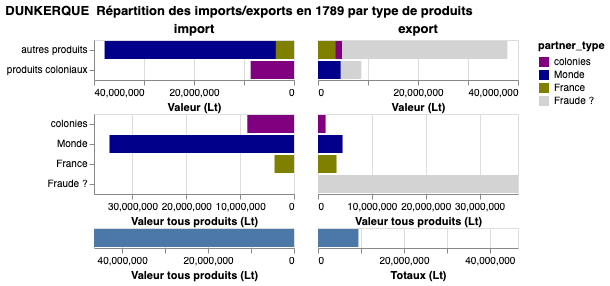

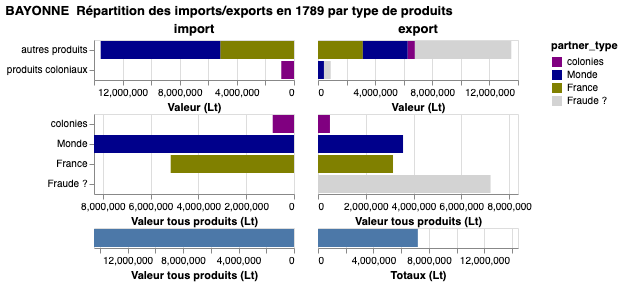

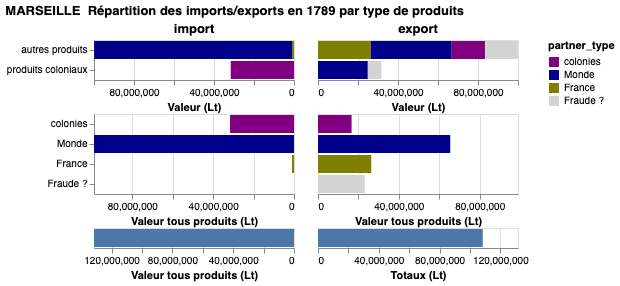

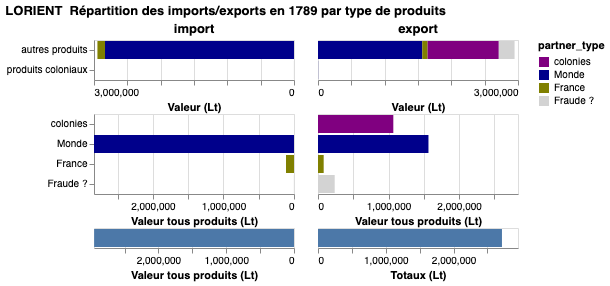

In [5]:
for city in ["Dunkerque", "Bayonne", "Marseille", "Lorient"]:
    pyramide_port_franc(city, data[city]["total_trade"],"product_type", "partner_type", "type de produits")

# Focus sur les exportations

Nous allons dans un premier temps détailler les produits coloniaux pour identifier les produits concernés par les anomalies d'exporations.

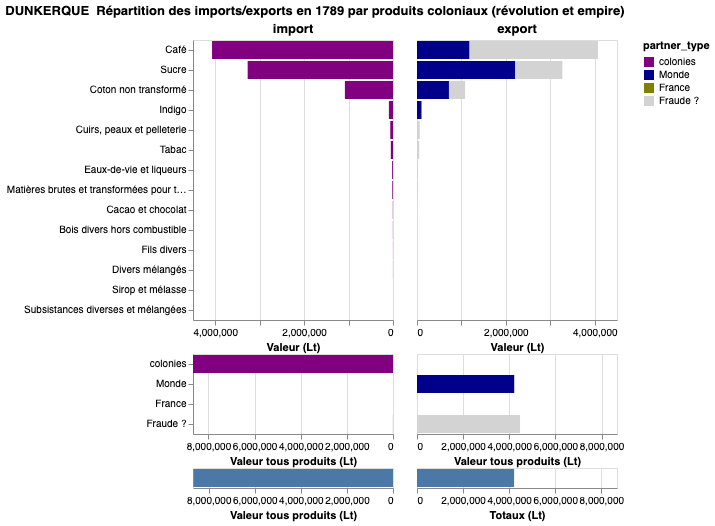

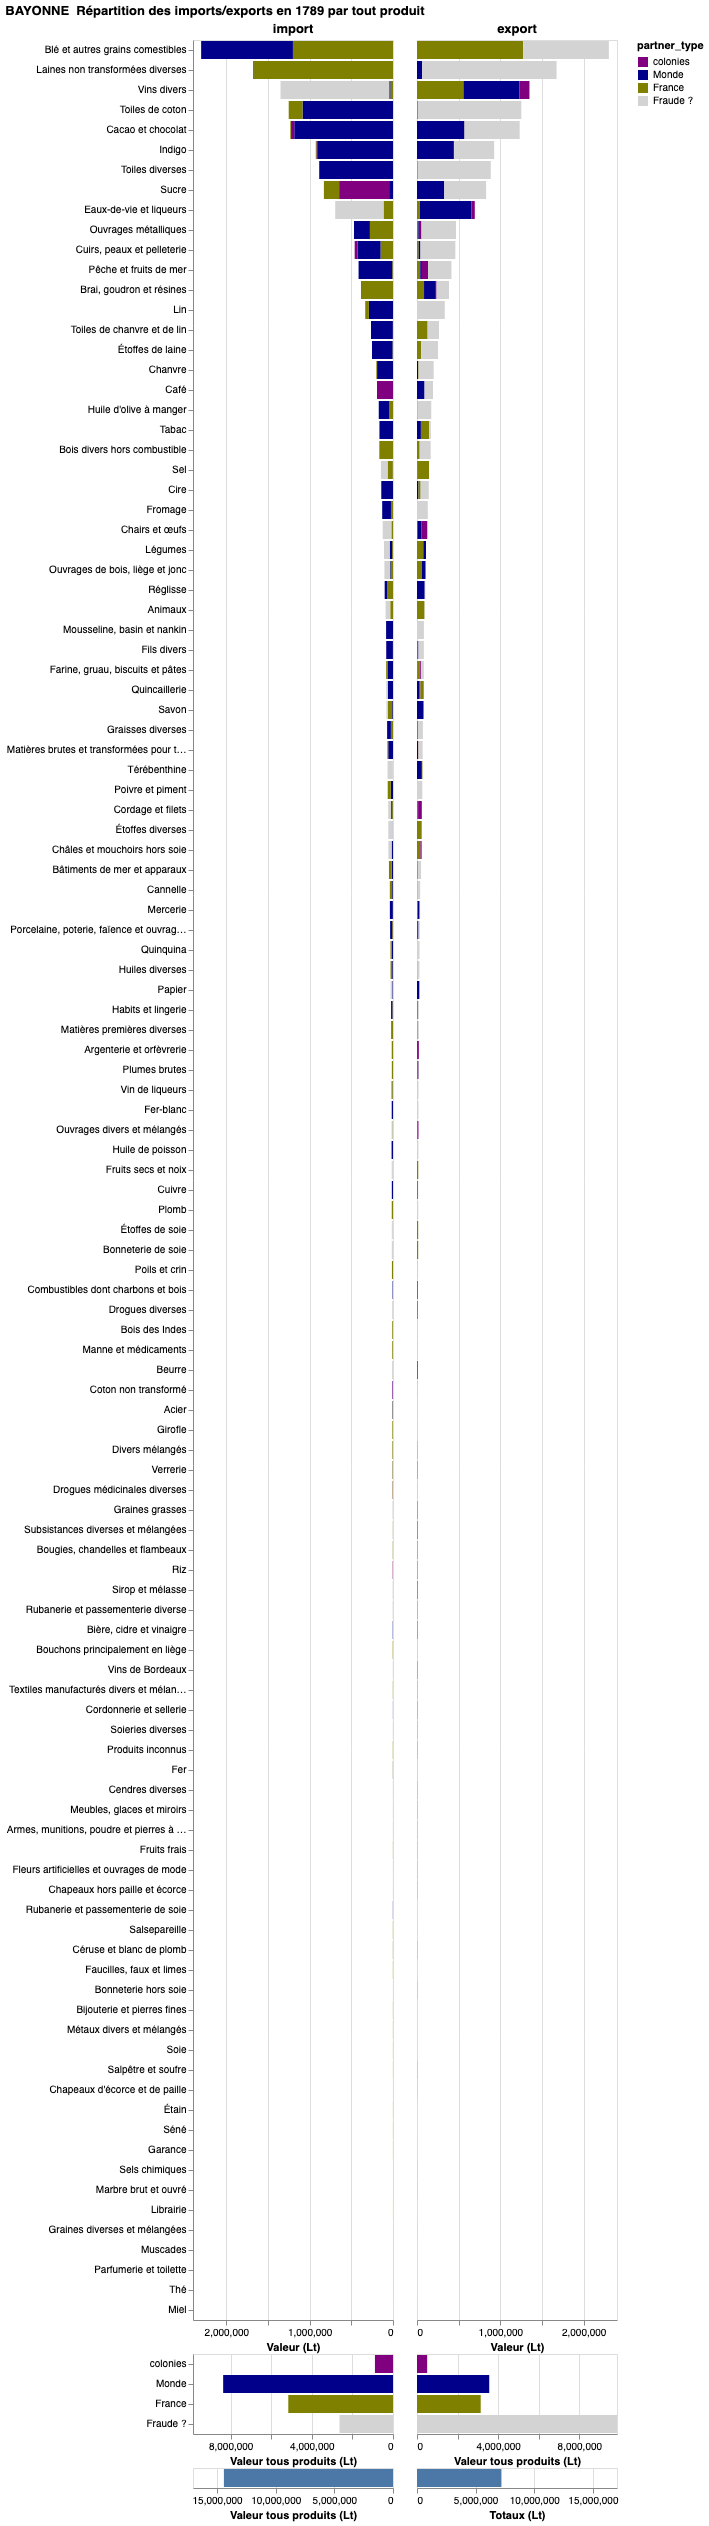

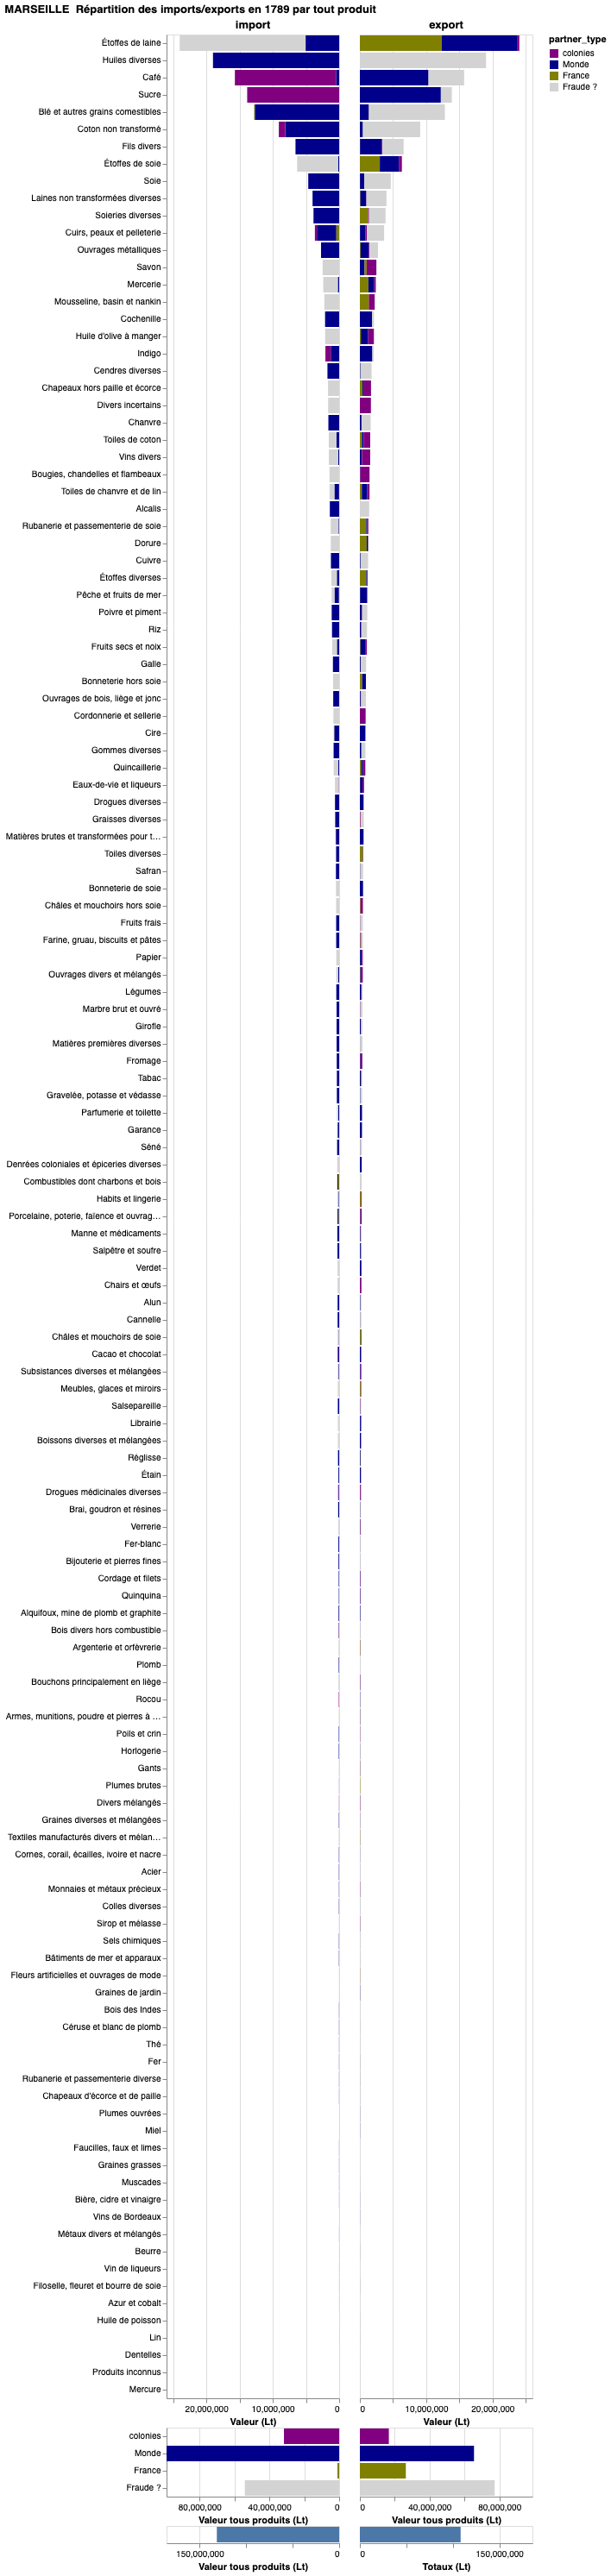

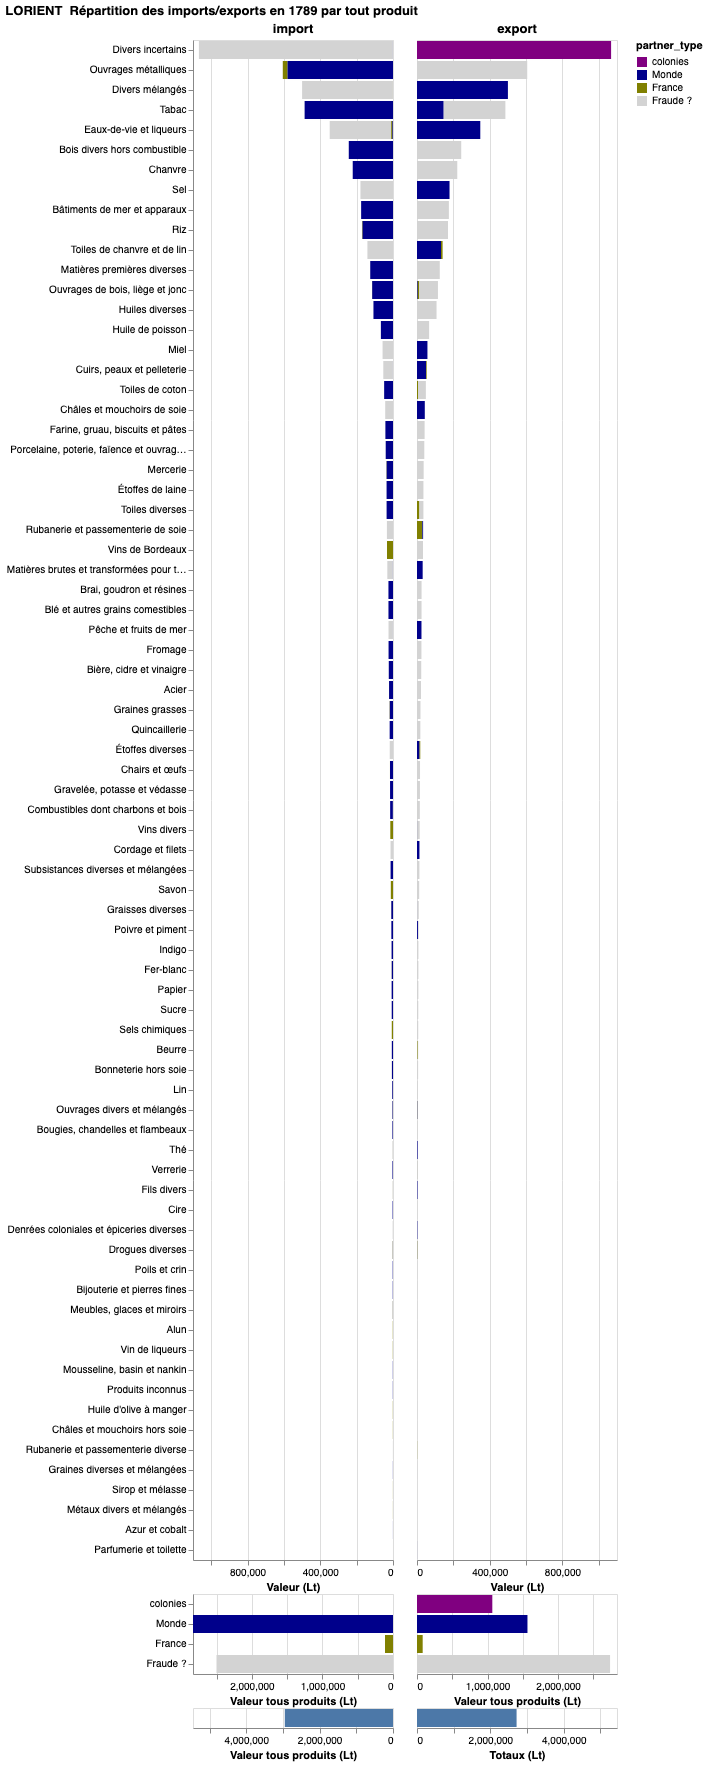

In [6]:
for city in ["Dunkerque", "Bayonne", "Marseille", "Lorient"]:
    pyramide_port_franc(city, data[city]["detail_products"], "product", "partner_type", "produits coloniaux (révolution et empire)" if city == "Dunkerque" else "tout produit")